## observe most frequent values of the categoricals

Home Assignment

Your assignment is to extract insights from the social media content, based on a month of Reddit data. You can download the data in the following link: 
https://drive.google.com/file/d/1tMZaD1CPBAH79uouzg0cKbwplWB1BPWR/view?usp=sharing

The submission should address the following tasks: 
A basic exploration of the data. 
List of ideas that popped into your head during your exploration. Everything that you think is interesting to explore should be here. 
Use topic clustering/modeling methods, in order to cluster Reddit’s/words. Then use these topics overtime to find interesting events in the data. In this part don’t use the “subreddit” column.
Evaluate your Reddits topic clustering/modeling results using the “subreddit” column (as tagged data for Reddit’s topic).

Guideline:
Please write clean code with documentation if needed.
Please explain your insights and analysis of your results.
Use methods for data cleaning.

Implement it in a Python notebook and analyze it.
Include instructions for running your code.
s

In [45]:
!pip install cluster
!pip install -U sentence-transformers
!pip install umap-learn hdbscan
!pip install plotly==5.6.0 
!pip install pyyaml==5.4.1

In [46]:
import pandas as pd
import numpy as np
import re

# from nltk.tokenize import word_tokenize
# from nltk.stem import WordNetLemmatizer
# from nltk.util import ngrams
# import nltk
# nltk.download(['punkt', 'wordnet', 'averaged_perceptron_tagger', 'stopwords'])

# nltk.download('stopwords')
# from nltk.metrics.distance import jaccard_distance
# from nltk.corpus import stopwords # nltk.download('stopwords')
# from cluster import HierarchicalClustering # pip install cluster

# from tqdm import tqdm
# # from tqdm.auto import tqdm  # for notebooks

# # Create new `pandas` methods which use `tqdm` progress
# # (can use tqdm_gui, optional kwargs, etc.)
# tqdm.pandas()

# from functools import lru_cache
from collections import Counter

import pickle


# Download data

In [47]:
!wget https://www.dropbox.com/s/czy80azezn19wib/Reddit_12_2008.csv.zip

--2022-02-10 20:56:17--  https://www.dropbox.com/s/czy80azezn19wib/Reddit_12_2008.csv.zip
Resolving www.dropbox.com (www.dropbox.com)... 162.125.81.18, 2620:100:6030:18::a27d:5012
Connecting to www.dropbox.com (www.dropbox.com)|162.125.81.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/czy80azezn19wib/Reddit_12_2008.csv.zip [following]
--2022-02-10 20:56:17--  https://www.dropbox.com/s/raw/czy80azezn19wib/Reddit_12_2008.csv.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucfbb27abbba9ce2d5f2a20f4092.dl.dropboxusercontent.com/cd/0/inline/Bfd8epIjpaqm4Q6Xr1b2Gn1JcQRxP16t_dh-jCofa1RkXn2wLTXHd9-XBbOq0F74jZ_TmogqnTChWPb42Ob-vNxkI_FHkAfqCJ5MDpisjjlx2LZdlf1AH1XXn6JELzinaVh-i7-katsyoyzJk6jngcXu/file# [following]
--2022-02-10 20:56:18--  https://ucfbb27abbba9ce2d5f2a20f4092.dl.dropboxusercontent.com/cd/0/inline/Bfd8epIjpaqm4Q6Xr1b2Gn1JcQRxP16t_dh-jCofa1RkXn2wLTXHd9-XB

In [48]:
!unzip -o Reddit_12_2008.csv.zip 

Archive:  Reddit_12_2008.csv.zip
  inflating: Reddit_12_2008.csv      
  inflating: __MACOSX/._Reddit_12_2008.csv  


In [49]:
df = pd.read_csv('Reddit_12_2008.csv')#.sample(50_000, random_state=7)
df

,author,body,created_utc,subreddit,id,score
0,malcontent,&gt;The business cannot survive paying out ben...,2008-12-18 08:00:37,politics,2,1
1,malcontent,"&gt;I'm curious, how do you see, beyond defini...",2008-12-18 08:00:41,politics,3,1
2,malcontent,"&gt;I'm curious, how do you see, beyond defini...",2008-12-18 08:00:53,politics,4,2
3,[deleted],[deleted],2008-12-18 08:01:07,WTF,5,1
4,catalytica,The greatest historic instigator of human divi...,2008-12-18 08:01:20,atheism,7,0
...,...,...,...,...,...,...
558348,[deleted],"Yeah, seriously. If anything it ""revalues"" mus...",2008-12-18 07:54:35,Music,c06vwuf,12
558349,Morgin_Black,"yes, beat it at failing.",2008-12-18 07:54:39,comics,c06vwug,0
558350,[deleted],Yes. This DRM will have the ability to send s...,2008-12-18 07:54:40,Economics,c06vwuh,1
558351,onezerozeroone,"To be fair, I think the original poster meant ...",2008-12-18 07:54:45,atheism,c06vwui,1


# Explore the data
A basic exploration of the data. List of ideas that popped into your head during your exploration. Everything that you think is interesting to explore should be here. 

## set dtypes

In [50]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 558353 entries, 0 to 558352
Data columns (total 6 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   author       558353 non-null  object
 1   body         558352 non-null  object
 2   created_utc  558353 non-null  object
 3   subreddit    558353 non-null  object
 4   id           558353 non-null  object
 5   score        558353 non-null  int64 
dtypes: int64(1), object(5)
memory usage: 25.6+ MB


In [51]:
df = df.convert_dtypes()
df['created_utc'] = pd.to_datetime( df.created_utc)
df['subreddit'] = df.subreddit.astype("category")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 558353 entries, 0 to 558352
Data columns (total 6 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   author       558353 non-null  string        
 1   body         558352 non-null  string        
 2   created_utc  558353 non-null  datetime64[ns]
 3   subreddit    558353 non-null  category      
 4   id           558353 non-null  string        
 5   score        558353 non-null  Int64         
dtypes: Int64(1), category(1), datetime64[ns](1), string(3)
memory usage: 22.4 MB


## lets look at some asppects of the body, like its length



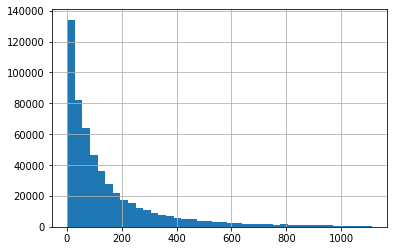

In [52]:
body_len = df.body.str.len()
body_len[body_len < body_len.quantile(0.98)].hist(bins=40)

In [53]:
df.body.describe()

count        558352
unique       475151
top       [deleted]
freq          74374
Name: body, dtype: object

looks like lots of bodies are suspiciously short, and uninformative. So we should delete all the "[deleted]" and "[[citation needed]" posts. If, later, we get into trouble clustering, we should revisit this step, and perhaps filter out more uninformative posts.

In [54]:
df = df.drop(df[df.body.str.len() <= 20].index)

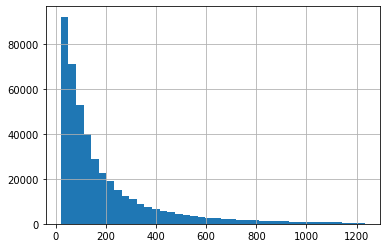

In [55]:
body_len = df.body.str.len()
body_len[body_len < body_len.quantile(0.98)].hist(bins=40)

In [56]:
df.body.describe()

count                        447523
unique                       444871
top       I see what you did there.
freq                             58
Name: body, dtype: object

Now, that looks a lot more normal

## are there any nulls?

In [57]:
df.isna().sum()

author         0
body           1
created_utc    0
subreddit      0
id             0
score          0
dtype: int64

if so, remove the nulls

In [58]:
df = df.dropna()

## observe most frequent values of the categoricals

In [60]:
import matplotlib.pyplot as plt


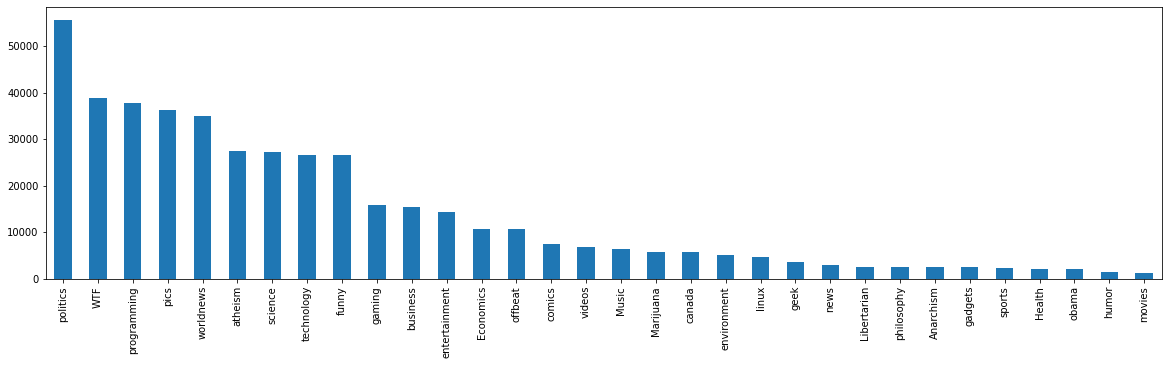

In [61]:
df.subreddit.value_counts().plot(ax=plt.subplots()[1], figsize=(20,5), kind='bar')

Looks like there's a long tail of subreddits. 

Since this is a target column, for simplicity, let's drop posts of rare subreddits, those that constitute < 1% of the dataset.

In [62]:
N = df.shape[0]
print(f'total posts == {N}, # subreddits == {df.subreddit.unique().shape[0]}')
min_freq = N // 100
print(f'removing posts of subreddits with less than {min_freq} posts')
vc = df.subreddit.value_counts()
subreddits_to_retain = set(vc[vc > min_freq].index)
df = df.loc[df.subreddit.isin(subreddits_to_retain), :]
new_N = df.shape[0]
print(f'The new # total posts == {new_N}')
n_target_clusters = len(subreddits_to_retain)
print(f'Now {n_target_clusters} non-rare subreddits remain.')
print(f'They are: {subreddits_to_retain}')

df['subreddit'] = df.loc[:,'subreddit'].astype("string").astype("category")

total posts == 447523, # subreddits == 32
removing posts of subreddits with less than 4475 posts
The new # total posts == 421073
Now 21 non-rare subreddits remain.
They are: {'environment', 'pics', 'comics', 'business', 'WTF', 'science', 'politics', 'offbeat', 'worldnews', 'funny', 'Marijuana', 'atheism', 'Music', 'entertainment', 'canada', 'videos', 'Economics', 'programming', 'linux', 'gaming', 'technology'}


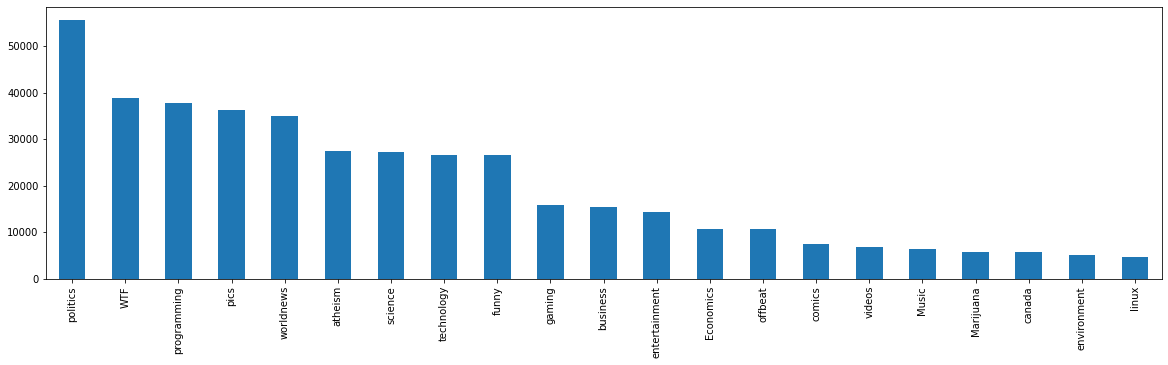

In [63]:
df.subreddit.value_counts().plot(ax=plt.subplots()[1], figsize=(20,5), kind='bar')

Looks like we've trimmed that long tail

## What is the average length of posts, broken by subreddit

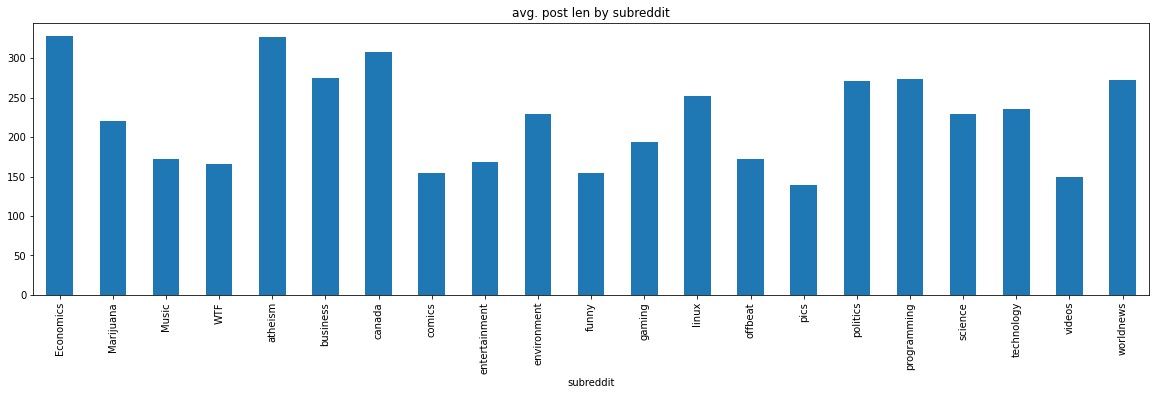

In [64]:
df.groupby('subreddit').agg({'body': lambda texts: texts.map(len).mean()}).body.plot.bar( figsize=(20, 5), 
                                                                                         title="avg. post len by subreddit")

Most posts are 100-200 chars long, which is short, like tweets. So further below we should consider tools that work well on short texts of social media.

Otherwise, this seems like a legitimate, fairly-uniform, distribution.

## Observe and get a feeling for  a sample of individual posts

use the interactive table feature (built in to colab) to filter and sort

In [65]:
df.sample(1000, random_state=7)[['body']]

,body
11790,I upmodded because I'm drunk.
428179,"I define quality as not being ""worse"". It's ti..."
47317,[Mass Effect on Steam does not have SecuROM](h...
71365,But look at how many politicians have died in ...
497879,And that chemical release is absolutely essent...
...,...
331675,"Rather obvious good cop, bad cop routine. The..."
1555,"if he does, it will be because he thinks so......"
502341,she could have killed two birds with one stone...
315560,[Modest Mouse and Califone - South of Heaven](...


Seems like we will want to remove some common nonsensical tokens like "%gt;" and URLs. 
There's some slang and typos, but not much. So we might need to use a byte pair based embedding scheme, to embed the non standard languge, and we might do fine w/o that.

## Here's the distribution of "Score". not sure what this column means, so I have nothing to say

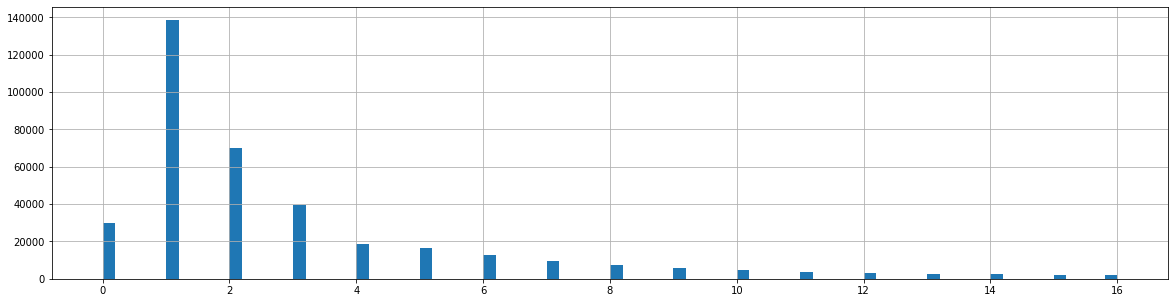

In [66]:
df[(df.score< df.score.quantile(0.95)) & (df.score > df.score.quantile(0.05)) ].score.hist(bins=80, figsize=(20, 5))

## look at stats on other columns

In [67]:
cols = df.columns.to_list()
cols.remove('score')
df[cols].describe()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning:

Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.



,author,body,created_utc,subreddit,id
count,421073,421073,421073,421073,421073
unique,26077,418553,384957,21,421073
top,[deleted],I see what you did there.,2008-12-12 21:28:16,politics,2
freq,87686,55,6,55612,1
first,NaN,NaN,2008-12-01 02:00:02,NaN,NaN
last,NaN,NaN,2009-01-01 01:59:58,NaN,NaN


## look for some changes over time

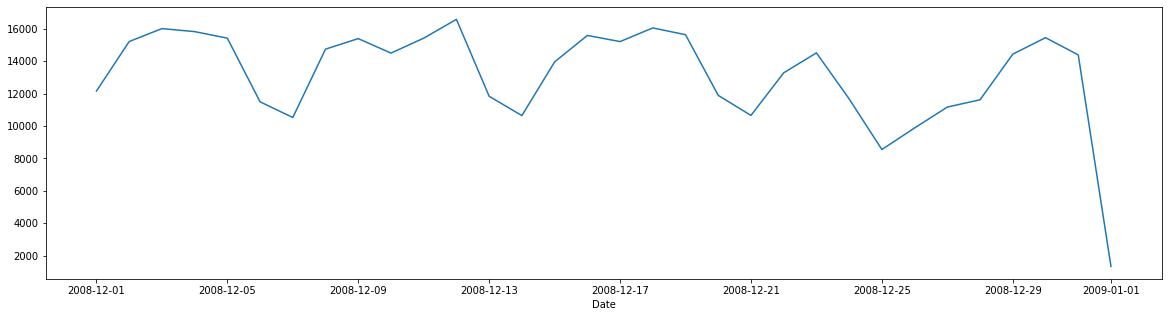

In [68]:
df.groupby(df['created_utc'].rename('Date').dt.date).size().plot(figsize=(20,5))

Looks like ppl post a lot at work, and post a little on wknds and holidays (xmas)

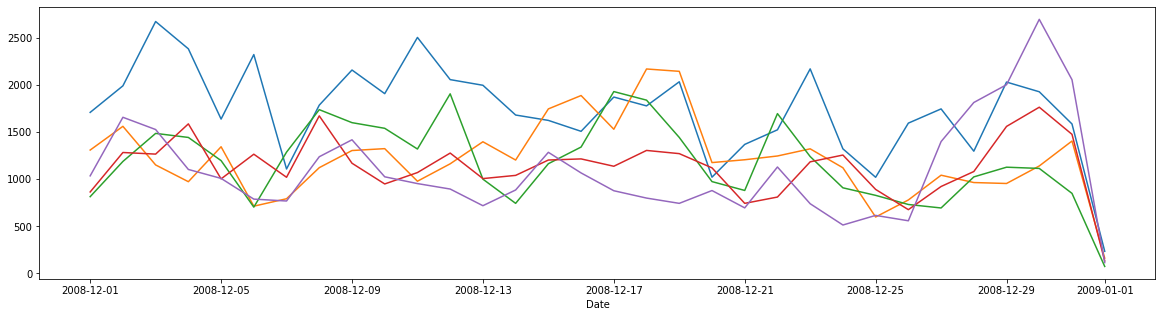

In [69]:
top_5_subreddits = df.subreddit.value_counts().index[:5].tolist()
top_5_subreddits
for subreddit in top_5_subreddits:
  df[df.subreddit==subreddit].groupby(df['created_utc'].rename('Date').dt.date).size().plot(figsize=(20,5))


Looks like the top 5 most popular subreddits follow the pattern as the whole, with some small variations and skews. we'll look deeper into time patterns below.

at what time do ppl post?

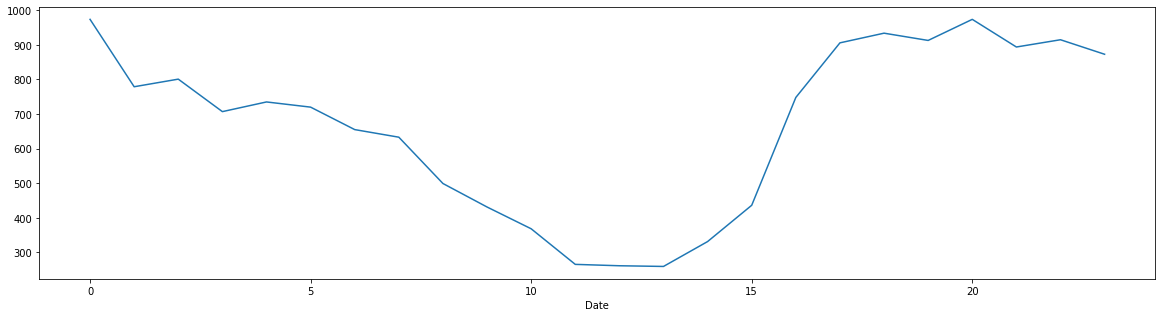

In [70]:
(df[(df.created_utc >= '2008-12-03') & (df.created_utc <= '2008-12-04')]
 .groupby(df['created_utc']
          .rename('Date').dt.hour)
 .size()
 .plot(figsize=(20,5)))

Seems like most posts occur between 17:00 and 01:00 UTC, so probably most authors live around the US west coast. 

## Look at author

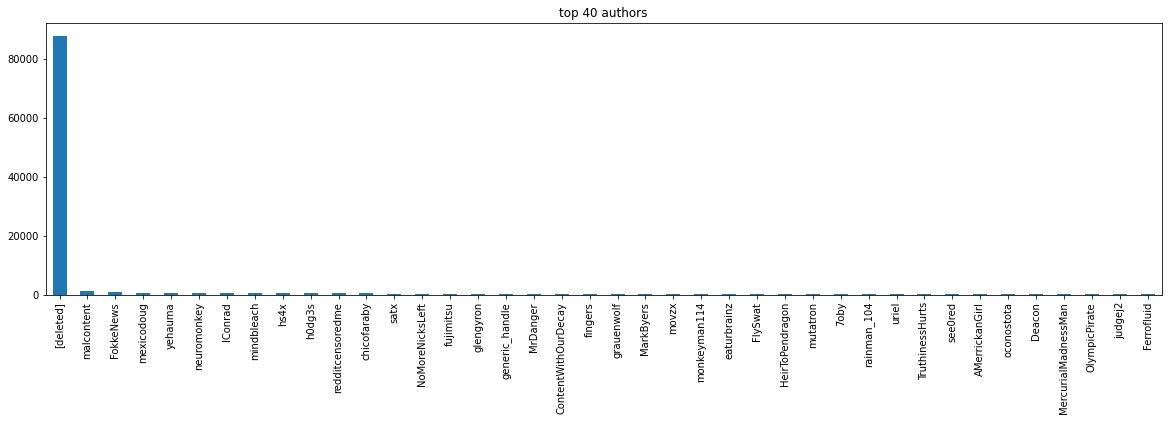

In [71]:
df.author.value_counts()[:40].plot(ax=plt.subplots()[1], 
                                   figsize=(20,5), 
                                   kind='bar',
                                   title='top 40 authors'
                                   )

Seems like most posts were made by users that have been deleted.

So what's the distribution of authors that are not "deleted"?

...Seems there's a long tail

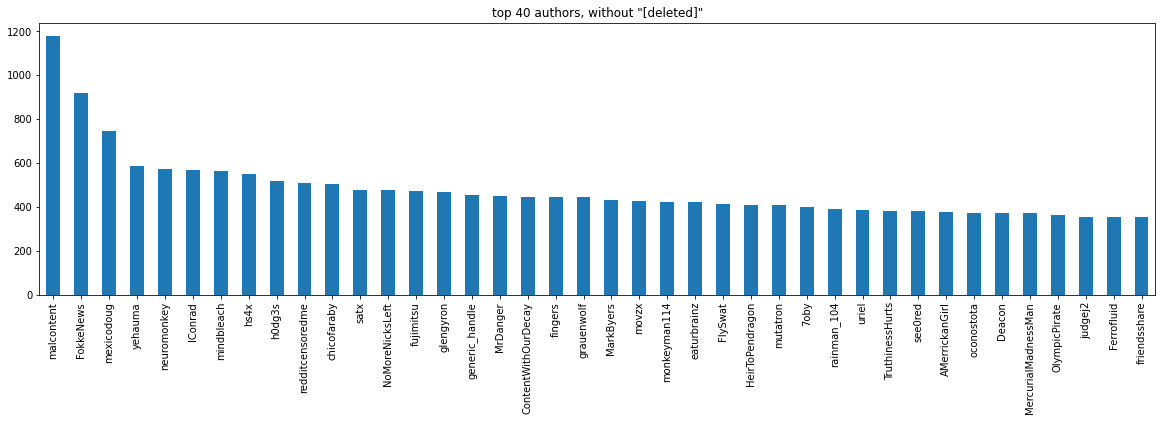

In [72]:
(df.author
 .drop(df[df.author == '[deleted]'].index).value_counts()[:40].plot(ax=plt.subplots()[1], 
                                                                    figsize=(20,5), 
                                                                    kind='bar',
                                                                    title='top 40 authors, without "[deleted]"'
                                                                    ))


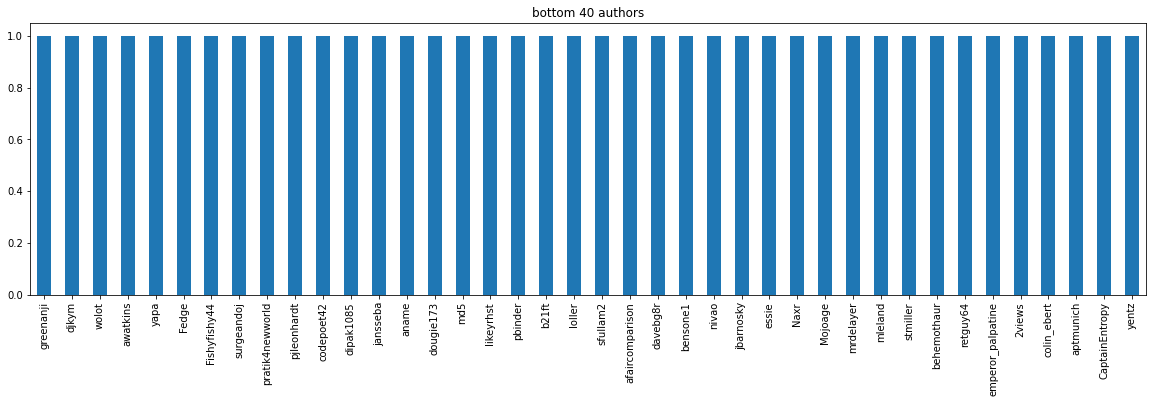

In [73]:
df['author'].drop(df[df.author == '[deleted]'].index).value_counts()
(df.author
 .drop(df[df.author == '[deleted]'].index).value_counts()[-40:].plot(ax=plt.subplots()[1], 
                                                                    figsize=(20,5), 
                                                                    kind='bar',
                                                                    title='bottom 40 authors'
                                                                    ))

## reset index, to keep tidy


In [74]:
df.reset_index(drop=True, inplace=True)

# Clean the text b4 embedding

remove URLs and "&" expressions

In [75]:
url_pattern = r'https?:\/\/(www\.)?[-a-zA-Z0-9@:%._\+~#=]{1,256}\.[a-zA-Z0-9()]{1,6}\b([-a-zA-Z0-9()@:%_\+.~#?&//=;\\]*)'

# remove URLs, and stuff like numbers &gt;, &amb; ...
# TODO instead of removing all numbers, extract/label dates using a tool like duckling. 
df['body_clean'] = (df.body
                           .str.replace(url_pattern + r'|&\w?\w?\w?\w;|[\d\\/\[\]()]+', ' ', regex=True)
                          #  .str.replace(r'\W', ' ', regex=True)
                           )
df.sample(1000, random_state=7)[['body', 'body_clean']]

,body,body_clean
8979,I upmodded because I'm drunk.,I upmodded because I'm drunk.
323880,"I define quality as not being ""worse"". It's ti...","I define quality as not being ""worse"". It's ti..."
35781,[Mass Effect on Steam does not have SecuROM](h...,Mass Effect on Steam does not have SecuROM ...
53828,But look at how many politicians have died in ...,But look at how many politicians have died in ...
376362,And that chemical release is absolutely essent...,And that chemical release is absolutely essent...
...,...,...
251015,"Rather obvious good cop, bad cop routine. The...","Rather obvious good cop, bad cop routine. The..."
1144,"if he does, it will be because he thinks so......","if he does, it will be because he thinks so......"
379661,she could have killed two birds with one stone...,she could have killed two birds with one stone...
238778,[Modest Mouse and Califone - South of Heaven](...,Modest Mouse and Califone - South of Heaven ...


# Use hdbscan, pic a LM on reddit social media text or short texts, based on byte code, maybe fastText. maybe BART trained on twitter?
evaluate manually, not with score. 
use at least 1K posts per topics

if all else fails, try hirarchical clustering

load a language model with sentence-transformers package

## embed the posts with a LM trained for text similarity, and fine tuned on reddit texts.

In [76]:
from sentence_transformers import SentenceTransformer
sentences = ["This is an example sentence", "Each sentence is converted"]

model = SentenceTransformer('flax-sentence-embeddings/reddit_single-context_mpnet-base')
embeddings = model.encode(sentences)
print(embeddings.shape)

(2, 768)


In [ ]:
%%time
vecs = model.encode(df.body_clean.values)

In [ ]:
# with open('vecs.pickle', 'rb') as f:
#     vecs = pickle.load(f)

In [ ]:
vecs.shape

In [ ]:
with open('vecs.pickle', 'wb') as f:
    pickle.dump(vecs, f)

## reduce dimensionality with UMAP, to improve clustering performance (see some explanation [here](https://towardsdatascience.com/clustering-sentence-embeddings-to-identify-intents-in-short-text-48d22d3bf02e)), and cluster with HDBSCAN

In [ ]:
%%time
import umap, hdbscan

import sklearn.cluster as cluster
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score

In [ ]:
%%time
vecs_umap = umap.UMAP(
    n_components=50,
    random_state=42,
).fit_transform(vecs)

In [ ]:
# with open('vecs_umap.pickle', 'rb') as f:
#     vecs_umap = pickle.load(f)

In [ ]:
vecs_umap.shape

In [ ]:
with open('vecs_umap.pickle', 'wb') as f:
    pickle.dump(vecs_umap, f)

In [ ]:
subreddit_code = df.subreddit.cat.codes

### lets plot the vectors on a reduced 2D space, cross-referencing with the subreddit labels.
This should give us an idea of how well the embedding separate vectors of different subreddits. 

In [ ]:
%%time
vecs_umap2d = umap.UMAP(
    # n_neighbors=30,
    # min_dist=0.0,
    n_components=2,
    random_state=42,
).fit_transform(vecs)

with open('vecs_umap2d.pickle', 'wb') as f:
    pickle.dump(vecs_umap2d, f)

vecs_umap2d.shape

In [ ]:
plt.scatter(vecs_umap2d[:, 0], vecs_umap2d[:, 1],
            c=subreddit_code, s=0.1, cmap='Spectral');

Looks like all embeddings are by-and-large lumped together, and/or the subreddit topics overlap a lot to begin with. 

Still, a few semi coherent monochrome lumps can be spotted. 

All in all, that's not an encouraging picture, but nonetheless lets see how far can we get with these embeddings. 

### cluster with HDBSCAN

In [ ]:
from sklearn.metrics.pairwise import pairwise_distances

In [ ]:
%%time
from sklearn.preprocessing import normalize

vecs_umap = normalize(vecs_umap, norm='l2')

In [ ]:
%%time 
clusters = hdbscan.HDBSCAN(
    min_cluster_size = 200,
    metric='euclidean', 
    # cluster_selection_method='eom'
    ).fit_predict(vecs_umap)

## Evaluate clusters against the given subreddits

In [ ]:
print(f'# examples == {len(clusters)}')
vc = pd.value_counts(clusters)
print(f'# clusters == {len(vc)}')
vc

In [ ]:
print(f'''First, we see that most posts could not be clustered (got a -1). 
That's too bad.
Among those that were clustered, we got 16 different clusters, while our data has {n_target_clusters} subreddits.
That's also too bad.
But lets see if those 16 caught any notion of the topic of the post.''')

Lets calc two of the most popular score for measuring the quality of a clustering. 

Scores close to zero are bad, close to 1 are good

In [ ]:
(
    adjusted_rand_score(subreddit_code, clusters),
    adjusted_mutual_info_score(subreddit_code, clusters)
)

Looks like we got bad scores. But scoring functions for clustering are often misleading. Let's eyeball the 

In [ ]:
df['cluster'] = clusters
df


Lets use word clouds to eye ball how on-topic each cluster is

In [ ]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [ ]:
def plot_wordcloud(s, i):
  wordcloud = WordCloud().generate(s)

  # Display the generated image:
  print(f'cluster #{i}')
  plt.imshow(wordcloud, interpolation='bilinear')
  plt.axis("off")
  plt.show()

subreddits_by_cluster = df[df.cluster >= 0].groupby('cluster').agg({'subreddit': ' '.join}).subreddit.values   #apply(lambda s: plot_wordcloud)
for i, label_list in enumerate(subreddits_by_cluster):
  plot_wordcloud(label_list, i)

We can see that, 
1. there's a lot of noise, e.g. 'WTF' appears in several clusters, with no apparent connection to other topics in those clusters.
2. On the bright side, most of the clusters contain posts that share a coherent topic (according to their most salient subreddits). E.g., "worldnews and politics", "worldnews politics and canada", "Atheism and politics", "programming and linux", "gaming, technology, programming and entertainment", "music and entertainment". 

All in all, these results seem good enough for a first draft PoC, with no spare time for hyperparameter tuning, debugging, data curation, or other tweaking.



#  use these cluter-topics overtime to find interesting events in the data

## Look at days of a month

In [ ]:
import plotly.express as px

In [ ]:
def tally_clusters_by_date(small_df):
  small_df['date'] = small_df.created_utc.dt.date
  return small_df.groupby('date').agg({'cluster': len}).rename(columns={'cluster': 'cluster_count'})
  

df_tallied = df[df.cluster >= 0].groupby('cluster').apply(tally_clusters_by_date).reset_index()
df_tallied.head()

In [ ]:

fig = px.line(df_tallied, x='date', y='cluster_count', color='cluster', symbol="cluster")
fig.show()

Some observations:

1. looks like after xmas, ppl suddenly started posting a lot about  topic #2, which is about worldnews and politics, topic #14 (atheism, politics) and topic #12 (programming, technology).
2. topic #12 (programming, technology) is the most popular overall, and seems to be the most _weekly_, i.e., the traffic differene between working and non working days is the most pronounced. Most other topics get relatively higher traffic on days-off, and don't even dip on xmas. 
3. There seems to be a big surge in traffic about topics #12 (programming, tech)and #14 (atheism, politics) in the last full work week b4 xmas. maybe that's b/c ppl work more on that week, and also the more they work, the more they chat about politics??
4. topic #5 (business, economics) surges around 12 Dec, towards the end of the work week. Maybe ppl are doing some end of year bookkeeping or expenses, heh ?

## look at hours of a single work day

In [ ]:
def tally_clusters_by_date(small_df):
  small_df['date'] = small_df.created_utc.dt.date
  return small_df.groupby('date').agg({'cluster': len}).rename(columns={'cluster': 'cluster_count'})
  

df_tallied = df[df.cluster >= 0].groupby('cluster').apply(tally_clusters_by_date).reset_index()
df_tallied.head()

In [ ]:

fig = px.line(df_tallied, x='date', y='cluster_count', color='cluster', symbol="cluster")
fig.show()

## try embedding with FastText

In [ ]:
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-english/crawl-300d-2M-subword.zip

In [ ]:
import io

def load_vectors(fname):
    fin = io.open(fname, 'r', encoding='utf-8', newline='\n', errors='ignore')
    n, d = map(int, fin.readline().split())
    data = {}
    for line in fin:
        tokens = line.rstrip().split(' ')
        data[tokens[0]] = map(float, tokens[1:])
    return data

In [ ]:
!unzip -o crawl-300d-2M-subword.zip

In [ ]:
model = load_vectors('crawl-300d-2M-subword.vec')

In [ ]:
import fastText as ft

# Loading model for Finnish.
model = ft.load_model('crawl-300d-2M-subword.bin')


In [ ]:
import umap, hdbscan
def generate_clusters(message_embeddings,
                      n_neighbors,
                      n_components, 
                      min_cluster_size,
                      random_state = None):
    """
    Generate HDBSCAN cluster object after reducing embedding dimensionality with UMAP
    """
    
    # umap_embeddings = (umap.UMAP(
    #     n_neighbors=n_neighbors, 
    #     n_components=n_components, 
    #     metric='cosine', 
    #     random_state=random_state)
    #     .fit_transform(message_embeddings))
    umap_embeddings = message_embeddings

    clusters = hdbscan.HDBSCAN(min_cluster_size = min_cluster_size,
                               metric='euclidean', 
                               cluster_selection_method='eom').fit(umap_embeddings)

    return clusters, umap_embeddings

In [ ]:
%%time
clusters, umap_embeddings = generate_clusters(vecs, 
                                              n_neighbors=6,
                                              n_components=9,
                                              min_cluster_size=60, 
                                              random_state=7)

In [ ]:
umap_embeddings.shape

In [ ]:
len(clusters.labels_)

In [ ]:
(
    adjusted_rand_score(subreddit_code, clusters.labels_),
    adjusted_mutual_info_score(subreddit_code, clusters.labels_)
)

In [ ]:
clusterable_embedding = umap.UMAP(
    n_neighbors=30,
    min_dist=0.0,
    n_components=50,
    random_state=42,
).fit_transform(vecs)


In [ ]:
plt.scatter(clusterable_embedding[:, 0], clusterable_embedding[:, 1],
            c=subreddit_code, s=0.1, cmap='Spectral');

In [ ]:
labels = hdbscan.HDBSCAN(
    min_samples=10,
    min_cluster_size=500,
).fit_predict(clusterable_embedding)

In [ ]:
clustered = (labels >= 0)
plt.scatter(clusterable_embedding[~clustered, 0],
            clusterable_embedding[~clustered, 1],
            color=(0.5, 0.5, 0.5),
            s=0.1,
            alpha=0.5)
plt.scatter(clusterable_embedding[clustered, 0],
            clusterable_embedding[clustered, 1],
            c=labels[clustered],
            s=0.1,
            cmap='Spectral');

In [ ]:
(
    adjusted_rand_score(subreddit_code, labels),
    adjusted_mutual_info_score(subreddit_code, labels)
)

url_pattern = r'https?:\/\/(www\.)?[-a-zA-Z0-9@:%._\+~#=]{1,256}\.[a-zA-Z0-9()]{1,6}\b([-a-zA-Z0-9()@:%_\+.~#?&//=;\\]*)'


# remove stop words to clean up tokenized text
def remove_stopwords(words):
    """ Removes stopwords based on a known set of stopwords
    available in the nltk package.
    """
    # set of stopwords from nltk
    stopwords = nltk.corpus.stopwords.words('english')

    stopwords_removed = [word for word in words if word not in stopwords]
    return stopwords_removed

# remove punctuation
@lru_cache()
def clean_text(text):
    if not text:
      return ''

    # remove URLs, and stuff like numbers &gt;, &amb; ...
    # TODO instead of removing all numbers, extract/label dates using a tool like duckling. 
    text = re.sub(url_pattern + r'|&\w?\w?\w?\w;|[\d\\/\[\]()]+', ' ', text)
    text = re.sub(r'\W', ' ', text)
    text = text.lower()
    tokenized_text = nltk.word_tokenize(text)
    replaced_punctation = list(map(lambda token: re.sub('[^0-9A-Za-z!?]+', ' ', token), tokenized_text))
    removed_punctation = list(filter(lambda token: token.strip(), replaced_punctation))
    removed_stopwords = remove_stopwords(removed_punctation)
    cleaned_text = ' '.join(removed_stopwords)
    return cleaned_text


df['body_cleaned']= df.body.iloc[:].apply(clean_text)
df

In [ ]:
# remove words less than 2 in length
# ndc_prod_list = [s for s in ndc_prod_list if len(s) > 2]

# topic modeling w spacy and gensim

In [ ]:
# pip install pyLDAvis spacy

In [ ]:
import matplotlib.pyplot as plt
import gensim
import numpy as np
import spacy
import en_core_web_sm

from gensim.models import CoherenceModel, LdaModel, LsiModel, HdpModel
from gensim.models.wrappers import LdaMallet
from gensim.corpora import Dictionary
# import pyLDAvis.gensim

import os, re, operator, warnings
warnings.filterwarnings('ignore')  # Let's not pay heed to them right now
%matplotlib inline

In [ ]:
nlp = en_core_web_sm.load()


In [ ]:
my_stop_words = [u'say', u'\'s', u'think', u'be', u'said', u'says', u'saying', 'know', 'don_t', 'want', 'like']
for stopword in my_stop_words:
    lexeme = nlp.vocab[stopword]
    lexeme.is_stop = True

In [ ]:
def spacy_clean(text):
  article = []
  # we add some words to the stop word list
  doc = nlp(text)
  for w in doc:
      # if it's not a stop word or punctuation mark, add it to our article!
      if (w.text != '\n' and 
          not w.is_stop and 
          not w.is_punct and 
          not w.like_num and 
          len(w.text.strip()) > 2
          ):
          # we add the lematized version of the word
          article.append(w.lemma_)
  return article

In [ ]:
from tqdm import tqdm
# from tqdm.auto import tqdm  # for notebooks

# Create new `pandas` methods which use `tqdm` progress
# (can use tqdm_gui, optional kwargs, etc.)
tqdm.pandas()

In [ ]:
%%time
texts = df.training_bow_documents.apply(spacy_clean)
texts[:10]

In [ ]:
type(texts[0][3])

## TFIDF top words --> ROBERTA tokenizer --> KMeans

strings = [' '.join(tokens) for tokens in texts]

import pandas as pd
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
import random
import numpy as np
from transformers import RobertaTokenizer

# Clustering using TfidfVectorizer method
tf_idf_vectorizor = TfidfVectorizer(stop_words = 'english',
                                    max_features = 20000,
                                    max_df = 0.8,
                                    ngram_range=(1,2)
                                    )
tf_idf = tf_idf_vectorizor.fit_transform(strings)
tf_idf_array = tf_idf.toarray()
kmeans = KMeans(n_clusters=n_target_clusters, algorithm = 'auto') #2
kmeans.fit(tf_idf_array)
KMeans(n_clusters=n_target_clusters)
cluster_assignment = kmeans.labels_
clustered_sentences = [[] for i in range(n_target_clusters)]
for sentence_id, cluster_id in enumerate(cluster_assignment):
    clustered_sentences[cluster_id].append(strings[sentence_id])

for i, cluster in enumerate(clustered_sentences):
    print("Cluster ", i+1)
    print(cluster[:10])
    print("")



roberta_tokenizer = RobertaTokenizer.from_pretrained("roberta-base")

total_array = np.array([roberta_tokenizer.encode_plus(strings[0],add_special_tokens=True,max_length=30,pad_to_max_length=True,return_attention_mask=True)['input_ids']])

for i in strings[1:]:
    new_array = np.array([roberta_tokenizer.encode_plus(i,add_special_tokens=True,max_length=30,pad_to_max_length=True,return_attention_mask=True)['input_ids']])
    total_array = np.append(total_array,new_array,axis=0)

clustered_sentences = [[] for i in range(n_target_clusters)]
for sentence_id, cluster_id in enumerate(cluster_assignment):
    clustered_sentences[cluster_id].append(strings[sentence_id])

for i, cluster in enumerate(clustered_sentences):
    print("Cluster ", i+1)
    print(cluster[:10])
    print("")


## back to topic modeling

In [ ]:
bigram = gensim.models.Phrases(texts)

In [ ]:
texts = [bigram[line] for line in texts]

In [ ]:
dictionary = Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

In [ ]:
hdpmodel = HdpModel(corpus=corpus, id2word=dictionary)

In [ ]:
hdp_topics = hdpmodel.show_topics()
hdp_topics

In [ ]:
len(hdpmodel.show_topics())

In [ ]:
def compare_hdp_top_topic_w_subreddit(ndx):
  vector = hdpmodel[corpus[ndx]]
  print(hdp_topics[pd.Series(tpl[1] for tpl in vector).argmax()])
  print(df.iloc[ndx][['subreddit', 'body']])

In [ ]:
for i in range(20):
  compare_hdp_top_topic_w_subreddit(i)

In [ ]:
lsimodel = LsiModel(corpus=corpus, num_topics=n_target_clusters, id2word=dictionary)

In [ ]:
lsi_topics = lsimodel.show_topics()  # Showing only the top 5 topics
lsi_topics

In [ ]:
vector = lsimodel[corpus[4]]
vector

In [ ]:
def compare_top_topic_w_subreddit(ndx):
  vector = lsimodel[corpus[ndx]]
  print(lsi_topics[pd.Series(tpl[1] for tpl in vector).argmax()])
  print(df.iloc[ndx][['subreddit', 'body']])

In [ ]:
for i in range(20):
  compare_top_topic_w_subreddit(i)

# Contextual Topic Modeling

In [ ]:
%%capture
!pip install contextualized-topic-models==1.8.1
!pip install torch==1.6.0+cu101 torchvision==0.7.0+cu101 -f https://download.pytorch.org/whl/torch_stable.html

In [ ]:
from contextualized_topic_models.models.ctm import CombinedTM
from contextualized_topic_models.utils.data_preparation import bert_embeddings_from_file, TopicModelDataPreparation
from contextualized_topic_models.datasets.dataset import CTMDataset
from contextualized_topic_models.evaluation.measures import CoherenceNPMI, InvertedRBO
from gensim.corpora.dictionary import Dictionary
from gensim.models import ldamodel 
import os
import numpy as np
import pickle

In [ ]:
url_pattern = r'https?:\/\/(www\.)?[-a-zA-Z0-9@:%._\+~#=]{1,256}\.[a-zA-Z0-9()]{1,6}\b([-a-zA-Z0-9()@:%_\+.~#?&//=;\\]*)'

# remove URLs, and stuff like numbers &gt;, &amb; ...
# TODO instead of removing all numbers, extract/label dates using a tool like duckling. 
df['training_bow_documents'] = (df.body
                           .str.replace(url_pattern + r'|&\w?\w?\w?\w;|[\d\\/\[\]()]+', ' ', regex=True)
                           .str.replace(r'\W', ' ', regex=True)
                           )
df

In [ ]:
tp = TopicModelDataPreparation("bert-base-nli-mean-tokens")

training_dataset = tp.create_training_set(df.body, df.body_cleaned)

In [ ]:
tp.vocab[:10]

In [ ]:
ctm = CombinedTM(input_size=len(tp.vocab), bert_input_size=768, num_epochs=200, n_components=n_target_clusters)
ctm.fit(training_dataset)  

In [ ]:
ctm.get_topic_lists(5)

## compare to subreddit values

In [ ]:
# print(training_dataset[0])

predictions = ctm.get_doc_topic_distribution(training_dataset, n_samples=20)

topic_index = np.argmax(predictions[0])
topic_words = ctm.get_topic_lists(5)[topic_index]
topic_words

In [ ]:
for i in range(20):
  topic_index = np.argmax(predictions[i])
  topic_words = ctm.get_topic_lists(5)[topic_index]
  print(topic_words)
  print(df.iloc[i].subreddit, f'body: "{df.iloc[i].body[:100]}..."')
  print()

# Cluster


Use topic clustering/modeling methods, in order to cluster Reddit’s/words.  In this part don’t use the “subreddit” column. Evaluate your Reddits topic clustering/modeling results using the “subreddit” column (as tagged data for Reddit’s topic).

## embed the posts using sentence-transformers and MiniLM (specialized for semantic similarity), and cluster with KMeans

clean text for embedding: remove non dictionary words (coz the LM might not _understand_  them well), and URLs

remove URLs, and stuff like numbers "http", &gt;, &amb; ...


In [ ]:
url_pattern = r'https?:\/\/(www\.)?[-a-zA-Z0-9@:%._\+~#=]{1,256}\.[a-zA-Z0-9()]{1,6}\b([-a-zA-Z0-9()@:%_\+.~#?&//=;\\]*)'

# remove URLs, and stuff like numbers &gt;, &amb; ...
# TODO instead of removing all numbers, extract/label dates using a tool like duckling. 
df['body_b4_embedding'] = (df.body
                           .str.replace(url_pattern + r'|&\w?\w?\w?\w;|[\d\\/\[\]()]+', ' ', regex=True)
                           )
df

In [ ]:
!wget https://www.dropbox.com/s/1t3mhk1sl7l4inj/en_lemmas_clean.txt

In [ ]:
en_vocab = set(pd.read_csv('en_lemmas_clean.txt', names=['lemma']).lemma.dropna())
print(f'load {len(en_vocab)} english dictionary words from wiktionary, which we '
f'can use as a ± comprehensive list of standard English words. Here is a sample: {list(en_vocab)[:10]}')

In [ ]:
"nt" in en_vocab


load a language model with sentence-transformers package

In [ ]:
from sentence_transformers import SentenceTransformer
sentences = ["This is an example sentence", "Each sentence is converted"]

model = SentenceTransformer('sentence-transformers/all-mpnet-base-v2')
embeddings = model.encode(sentences)
print(embeddings.shape)

In [ ]:
%%time
vecs = model.encode(df.body_b4_embedding.values)

reduce dimensionality with UMAP, to improve clustering performance (see some explanation [here](https://towardsdatascience.com/clustering-sentence-embeddings-to-identify-intents-in-short-text-48d22d3bf02e))

and cluster with HDBSCAN

In [ ]:
%%time
import sklearn.cluster as cluster
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score

In [ ]:
import umap, hdbscan
def generate_clusters(message_embeddings,
                      n_neighbors,
                      n_components, 
                      min_cluster_size,
                      random_state = None):
    """
    Generate HDBSCAN cluster object after reducing embedding dimensionality with UMAP
    """
    
    # umap_embeddings = (umap.UMAP(
    #     n_neighbors=n_neighbors, 
    #     n_components=n_components, 
    #     metric='cosine', 
    #     random_state=random_state)
    #     .fit_transform(message_embeddings))
    umap_embeddings = message_embeddings

    clusters = hdbscan.HDBSCAN(min_cluster_size = min_cluster_size,
                               metric='euclidean', 
                               cluster_selection_method='eom').fit(umap_embeddings)

    return clusters, umap_embeddings

In [ ]:
%%time
clusters, umap_embeddings = generate_clusters(vecs, 
                                              n_neighbors=6,
                                              n_components=9,
                                              min_cluster_size=60, 
                                              random_state=7)

In [ ]:
umap_embeddings.shape

In [ ]:
subreddit_code = df.subreddit.astype('category').cat.codes

In [ ]:
len(clusters.labels_)

In [ ]:
(
    adjusted_rand_score(subreddit_code, clusters.labels_),
    adjusted_mutual_info_score(subreddit_code, clusters.labels_)
)

In [ ]:
clusterable_embedding = umap.UMAP(
    n_neighbors=30,
    min_dist=0.0,
    n_components=50,
    random_state=42,
).fit_transform(vecs)


In [ ]:
plt.scatter(clusterable_embedding[:, 0], clusterable_embedding[:, 1],
            c=subreddit_code, s=0.1, cmap='Spectral');

In [ ]:
labels = hdbscan.HDBSCAN(
    min_samples=10,
    min_cluster_size=500,
).fit_predict(clusterable_embedding)

In [ ]:
clustered = (labels >= 0)
plt.scatter(clusterable_embedding[~clustered, 0],
            clusterable_embedding[~clustered, 1],
            color=(0.5, 0.5, 0.5),
            s=0.1,
            alpha=0.5)
plt.scatter(clusterable_embedding[clustered, 0],
            clusterable_embedding[clustered, 1],
            c=labels[clustered],
            s=0.1,
            cmap='Spectral');

In [ ]:
(
    adjusted_rand_score(subreddit_code, labels),
    adjusted_mutual_info_score(subreddit_code, labels)
)

In [ ]:
standard_embedding = umap.UMAP(random_state=42).fit_transform(vecs)
plt.scatter(standard_embedding[:, 0], standard_embedding[:, 1], c=subreddit_code, s=0.1, cmap='Spectral');


In [ ]:
%%time
import sklearn.cluster as cluster
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score

# clusters = cluster.KMeans(n_clusters=n_target_clusters).fit_predict(vecs)
clusters = hdbscan.HDBSCAN(min_samples=10, min_cluster_size=500).fit_predict(vecs)

In [ ]:
clusters

In [ ]:
(
    adjusted_rand_score(subreddit_code, clusters),
    adjusted_mutual_info_score(subreddit_code, clusters)
)

In [ ]:
clustered = (clusters >= 0)
(
    adjusted_rand_score(subreddit_code[clustered], clusters[clustered]),
    adjusted_mutual_info_score(subreddit_code[clustered], clusters[clustered])
)


In [ ]:
clustered.sum()

In [ ]:
vc = pd.value_counts(clusters)
print(vc.shape)
vc

In [ ]:
clustered = (clusters >= 0)
plt.scatter(umap_embeddings[~clustered, 0],
            umap_embeddings[~clustered, 1],
            color=(0.5, 0.5, 0.5),
            s=0.1,
            alpha=0.5)
plt.scatter(umap_embeddings[clustered, 0],
            umap_embeddings[clustered, 1],
            c=clusters[clustered],
            s=0.1,
            cmap='Spectral');

In [ ]:
from nltk.util import bigrams


# Tweak this distance threshold and try different distance calculations 
# during experimentation
DISTANCE_THRESHOLD = 0.6
DISTANCE = jaccard_distance

def cluster_texts_with_jaccard(df):

    texts = df.body_cleaned.values

    clusters = {}
    for title1 in texts:
        clusters[title1] = Counter()
        for title2 in texts:
            if title2 in clusters[title1] or title2 in clusters and title1 \
                in clusters[title2]:
                continue
            try:
                distance = DISTANCE(set(title1.split()), set(title2.split()))
            except:
                print(title1.split())
                print(title2.split())
                continue

            if distance < DISTANCE_THRESHOLD:
                clusters[title1].append(title2)

    # Flatten out clusters
    clusters = [clusters[title] for title in clusters if len(clusters[title]) > 1]

    # Round up subreddits who are in these clusters and group them together
    subreddits = df.subreddit.values
    clustered_subreddits = {}
    for cluster in clusters:
        clustered_subreddits[tuple(cluster)] = []
        for subreddit in subreddits:
              if subreddit in cluster:
                  clustered_contacts[tuple(cluster)].append('{0} {1}.'.format(
                      contact['FirstName'], contact['LastName'][0]))

    return clustered_contacts


clustered_contacts = cluster_contacts_by_title()

for titles in clustered_contacts:
    common_titles_heading = 'Common Titles: ' + ', '.join(titles)

    descriptive_terms = set(titles[0].split())
    for title in titles:
        descriptive_terms.intersection_update(set(title.split()))
    if len(descriptive_terms) == 0: descriptive_terms = ['***No words in common***']
    descriptive_terms_heading = 'Descriptive Terms: ' \
        + ', '.join(descriptive_terms)
    print(common_titles_heading)
    print('\n'+descriptive_terms_heading)
    print('-' * 70)
    print('\n'.join(clustered_contacts[titles]))
    print()

# clusters over time


Then use these topics overtime to find interesting events in the data.